In [ ]:
import gym
import numpy as np
from gym import wrappers
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
from collections import namedtuple
import itertools
import math
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 64
        self.head = nn.Linear(linear_input_size, 256)
        self.output = nn.Linear(256, outputs)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.head(x.view(x.size(0), -1)))
        return self.output(x)
# class DQN(nn.Module):
#     def __init__(self, img_height, img_width, n_actions):
#         super(DQN, self).__init__()
#         self.fc1 = nn.Linear(img_height*img_width*3, 24)
#         self.fc2 = nn.Linear(24, 32)
#         self.fc3 = nn.Linear(32, n_actions)
#     def forward(self, x):
#         x = x.flatten(start_dim = 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)

In [ ]:
Experience = namedtuple("Experience", ('state', 'action', 'next_state', 'reward'))

In [ ]:
e = Experience(2, 3, 1, 4)

In [ ]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size
    def __len__(self):
        return len(self.memory)

In [ ]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * math.exp(-1. * current_step * self.decay)

In [7]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(device)

In [8]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make("CartPole-v0").unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
    def reset(self):
        self.env.reset()
        self.current_screen = None
    def close(self):
        self.env.close()
    def render(self, mode='human'):
        return self.env.render(mode = mode)
    def num_actions_available(self):
        return self.env.action_space.n
    def take_action(self, action):
        obs, reward, self.done, info = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)
    def just_starting(self):
        return self.current_screen is None
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1))
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom,:]
        return screen
    def transform_screen_data(self, screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)

        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40, 90)),
            T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# em = CartPoleEnvManager(device)

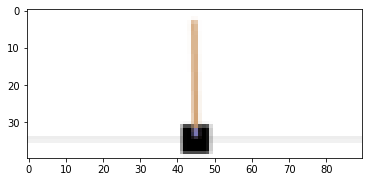

In [10]:
# screen = em.get_processed_screen()
# plt.imshow(screen.squeeze(0).permute(1, 2, 0), interpolation='none')

In [10]:
from IPython import display

In [11]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title("Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.01)
    print(f"Episode {len(values)}, Moving Avg: {moving_avg[-1]}")
    display.clear_output(wait=True)
    
def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

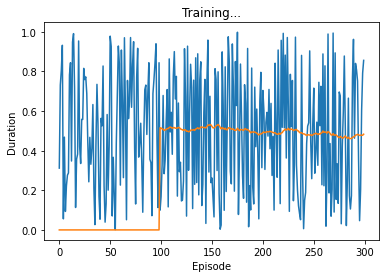

Episode 300, Moving Avg: 0.48334819078445435


In [12]:
plot(np.random.rand(300), 100)

In [13]:
class QValues():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index = actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

In [14]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
#     print(batch.action)
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    return (t1, t2, t3, t4)

In [15]:
batch_size = 128
gamma = 0.999
eps_start = 1
eps_end = 0.05
eps_decay = 200
target_update = 10
memory_size = 100000
lr = 0.01
num_episodes = 600

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [17]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width(), em.num_actions_available()).to(device)

In [18]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
  (head): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
)

In [19]:
optimizer = optim.Adam(policy_net.parameters())

In [20]:
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in itertools.count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values*gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-a720f3ab8022>", line 17, in <module>
    current_q_values = QValues.get_current(policy_net, states, actions)
  File "<ipython-input-13-aaeb3ccec22c>", line 6, in get_current
    return policy_net(states).gather(dim=1, index = actions.unsqueeze(-1))
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "<ipython-input-2-72fa50577466>", line 18, in forward
    x = F.relu(self.head(x.view(x.size(0), -1)))
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/module.py", line 722, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.7/site-packages/torch/nn/modules/linear.py", line 91, in forward
    return F.linear(input, self.weigh

KeyboardInterrupt: 

In [27]:
torch.save(policy_net.state_dict(), "dqn-cartpole-cnn-bn.pth")

/usr/local/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
policy_net.load_state_dict(torch.load("models/dqn-cartpole-cnn-bn.pth", map_location='cpu'))

In [32]:
done = False
cnt = 0
em.reset()
while not done:
    cnt += 1
    state = em.get_state()
    em.render()
    action = agent.select_action(state, policy_net)
    reward = em.take_action(action)
    if em.done:
        break

In [33]:
print(cnt)

16
